In [ ]:
import pandas as pd
import numpy as np
import re
import os
!pip install sentencepiece
import sentencepiece as spm
import pickle
import pathlib
from fastai.text import *
torch.cuda.set_device(0)

     |████████████████████████████████| 1.1MB 2.8MB/s 


In [ ]:

import fastai, torch
fastai.__version__ , torch.__version__

('1.0.61', '1.5.1+cu101')

In [ ]:
!unzip 'drive/My Drive/nlp-telugu/Telugu_dataset.zip'

In [ ]:
from collections import defaultdict
from pathlib import Path
import pandas as pd

def write_text(file):
    text = file.readlines()
    del text[0:6]
    del text[-1:-3]
    # text = [line.replace('\n', ' ') for line in text]
    text = [item for sublist in text for item in sublist]
    text2 = ''.join(text)
    text2 = text2.replace('\n', ' ').replace(',','')
    return text2

results = defaultdict(list)

for foldername in os.listdir('Telugu_dataset/2017/'):



    my_dir_path = "Telugu_dataset/2017/"+foldername+"/"

    for file in Path(my_dir_path).iterdir():
        with open(file, "r") as file_open:
            results["label"].append(foldername)
            results["text"].append(write_text(file_open))
data_df = pd.DataFrame(results)

In [ ]:
data_df.head

<bound method NDFrame.head of            label                                               text
0      editorial  అవగాహనతోనే ఎయిడ్స్ అంతం   ఏ ప్రాంతం వారైనా ఏ స...
1      editorial  బహు భాషా కవి సమ్మేళనం   తెలంగాణ అభ్యుదయ రచయితల...
2      editorial  బ్యాంకుల బాదుడు!   పెద్దనోట్ల రద్దు నాటి పరిస్...
3      editorial  రుద్రమ మరణం 1289లోనే...   సమకాలీన సాహిత్య గ్రం...
4      editorial  ‘దంగల్‌’ రాజకీయం   ముఖ్యమంత్రి మెహబూబా ముఫ్తీన...
...          ...                                                ...
29715  telangana  4 పట్టణాలకు ఔటర్‌ రింగ్‌ రోడ్లు: తుమ్మల  హైదరా...
29716  telangana  సాయి ప్రజల్వ మిస్సింగ్ మిస్టరీ వీడింది  హైదరాబ...
29717  telangana  పౌరసరఫరాలో పోలీస్‌ మార్క్‌  తనదైన ముద్ర వేసిన ...
29718  telangana  వైభవంగా నాగచైతన్య సమంత పెళ్లి   హిందూ సంప్రదాయ...
29719  telangana  మూడు రోజులు భారీ వర్షాలు  హైదరాబాద్‌ ఆగస్టు 16...

[29720 rows x 2 columns]>

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, shuffle=True)
train_df.shape, test_df.shape

((23776, 2), (5944, 2))

In [ ]:
train_df.to_parquet('telugu_news_train.parquet', index = None)
test_df.to_parquet('telugu_news_test.parquet', index = None)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [ ]:
from inltk.tokenizer import TeluguTokenizer
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [ ]:
data_lm = TextLMDataBunch.from_df('./', train_df=train_df, valid_df=test_df,
                                  text_cols=["text"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_cls_lm.data')

In [ ]:
data_lm.show_batch()

idx,text
0,నక ▁రాష్ట్రాల పై ▁దాడుల ను ▁కేంద్రం ▁జో క్య ాన్ని ▁ఎలా ▁ఎదుర్కో వాల న్నది ▁మాత్రం ▁అందరూ ▁ఆలోచించ ాల్సిన ▁విషయం . ▁కథా క ళి ▁నృత్య ానికి ▁కమ్యూనిస్టు ▁రాజకీయాల కు ▁ప్రసిద్ధిగాంచి న ▁కేరళ ▁ఇప్పుడు ▁బీజ ే పీ ▁కేంద్ర ▁నేత ల ▁మంత్రుల ▁రాజకీయ ▁యాత్ర లకు ▁కేంద్రంగా ▁మారడం ▁విచిత్ర ం ▁విశేషం . ▁తమ ▁కార్యకర్త లపై ▁హత్యా దా డులు ▁జరుగుతున్నాయి ▁గ నక ▁అక్కడ ున్న ▁పి న ర యి ▁విజయ న్ ▁ప్రభుత్వాన్ని ▁బర్ తర ఫ్ ▁చేయాలని ▁ఆ
1,▁గా ది గూడ ▁మండలం ▁కు ని కా స లలో ▁వైద్య ▁పరీక్షలు ▁నిర్వహిస్తున్న ామని ▁తెలిపారు . ▁ఆరోగ్య ▁శాఖ ▁మంత్రి ▁కార్యాలయం ▁ప్రత్యేక ▁అధికారి ▁డాక్టర్ ▁గంగాధర ్ ▁పర్యవేక్షణలో ▁ని మ్స్ ▁వైద్యులు ▁రి మ్స్ ▁వైద్యులు ▁పరీక్షలు ▁నిర్వహిస్తున్న ారని ▁తెలిపారు . ▁ <unk> ▁/ ▁ <unk> te x t <unk> ▁ <unk> ▁/ <unk> ▁d o c <unk> ▁x x bo s ▁ఐ ఐ ఐ టి - హెచ్ ▁తో ▁హై సియా ▁ఒప్పందం ▁హైదరాబాద్ ▁( ఆంధ్ర
2,న్ ▁ జిన్ ▁అమెరికాలోని ▁శాన్ ▁జోస్ ▁సి ఎ ▁హిల్స్ ▁బో రో ల్లోని ▁లా టిస్ ▁ఆస్తులు ▁150 ▁మంది ▁ఆర్ ▁అండ్ ▁డి ▁సిబ్బంది ▁లా బ్స్ ▁బద ల ాయి ంచ నున్నారు . ▁లా టిస్ ▁కు ▁చెందిన ▁హెచ్ ▁డి ఎం ఐ ▁డె వల్ ▁ప మెంట్ ▁టీ మ్ ▁ఆర్ ▁అండ్ ▁డి ▁లా బ్స్ ▁అనుబంధ ▁సంస్థ ▁సిం ప్లే ▁లా బ్స్ ▁ను ▁హస్తగత ం ▁చేసుకోవటం ▁ఎంతగానో ▁కలిసి ▁రాను ందని ▁ఇన్ వె కాస్ ▁చీఫ్ ▁ఎగ్జిక్యూటివ్ ▁డైరెక్టర్ ▁దశరథ ్
3,▁మద్దతు ▁బ్యాంకు ల్లో ▁వాటా ల ▁విక్రయ ం ▁ద్వారా ▁అందించ ను ంది . ▁మిగిలిన ▁1. 35 ▁లక్షల ▁కోట్ల ▁రూపాయల ను ▁బాండ్ ల ▁రూపంలో ▁జారీ ▁చేయ ను ంది . ▁సూక్ష్మ ▁చిన్న ▁మధ్య ▁తరహా ▁పరిశ్రమల ▁( ఎం ఎ ్ ▁స ఎం ఇ ) కు ▁రుణ ▁వితరణ ▁పెంచ ాలన్న ▁ఎం ఎ ్ ▁స ఎం ఇ ▁మంత్రిత్వ ▁శాఖ ▁అభ్యర్ధన పై ▁చర్చించ టంతో ▁పాటు ▁మొ ండి ▁ప ద్దు లు ▁రుణ ▁వృద్ధి ▁వంటి ▁వాటిపై ▁ఈ ▁సమావేశంలో ▁చర్చించ
4,bo s ▁శ్వేత ▁ఎక్స్ ▁పోర్ట్ స్ ▁కు ▁హైకోర్టు లో ▁చుక్క ె దురు ▁హామీ ▁ఆస్తుల ▁వేల ానికి ▁గ్రీన్ ▁సిగ్నల్ ▁హైదరాబాద్ ▁( ఆంధ్ర జ్యోతి ): ▁తూర్పుగోదావరి ▁జిల్లాలోని ▁శ్వేత ▁ఎక్స్ ▁పోర్ట్ స్ ▁ఇండియా కు ▁హైకోర్టు లో ▁చుక్క ె దు రై ంది . ▁బ్యాంక్ ▁ఆఫ్ ▁ఇండి ▁యా ▁నుంచి ▁రుణ ంగా ▁తీసుకున్న ▁మొత్తాన్ని ▁చెల్లించ కుండా ▁ఏదో ▁ఒక ▁ మిష తో ▁కాల య ాపన ▁చేయడాన్ని ▁హైకోర్టు ▁డివిజన్ ▁బెం చ్ ▁తప్పు బట్టి ంది . ▁తీసుకున్న ▁రుణ ాలను


In [ ]:
learn = load_learner('drive/My Drive/nlp-telugu/ulmfit2/', 'export.pkl')

In [ ]:
learn.save("./trained_model", return_path=True)

PosixPath('drive/My Drive/nlp-telugu/ulmfit2/models/trained_model.pth')

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25, pretrained=False)
learn = learn.to_fp16(clip=0.1)

In [ ]:
learn.load('trained_model', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (23776 items)
x: LMTextList
▁x x bo s ▁కేరళ లో ▁కాషాయ ▁కథా క ళి ! ▁అరవై ▁ఏళ్ల ▁కి ందట ▁ఇందిరాగాంధీ ▁‘ వి మో చన ▁యాత్ర ’ ▁చేయ లేకపోయిన ▁పని ▁అమిత ్ ▁షా ▁‘ రక్షణ ▁యాత్ర ’ ▁చే స్తు ందన ుకోవడం ▁హాస్య ాస్పద ం . ▁ఆయన ▁రక్షణ ▁యాత్ర ▁నుంచి ▁రాష్ట్ర ాన్ని ▁ప్రభుత్వాన్ని ▁ఎలా ▁రక్షించ ుకో వా లో ▁ప్రజల ే ▁చూసుకుంట ారు . ▁కాని ▁ప్రజాస్వామ్యం ▁లౌకిక తత్వం ▁సమాఖ్య ▁విధానం ▁మన ▁రాజ్యాంగ ానికి ▁మూడు ▁మూల ▁సూత్రాలు ▁గ నక ▁రాష్ట్రాల పై ▁దాడుల ను ▁కేంద్రం ▁జో క్య ాన్ని ▁ఎలా ▁ఎదుర్కో వాల న్నది ▁మాత్రం ▁అందరూ ▁ఆలోచించ ాల్సిన ▁విషయం . ▁కథా క ళి ▁నృత్య ానికి ▁కమ్యూనిస్టు ▁రాజకీయాల కు ▁ప్రసిద్ధిగాంచి న ▁కేరళ ▁ఇప్పుడు ▁బీజ ే పీ ▁కేంద్ర ▁నేత ల ▁మంత్రుల ▁రాజకీయ ▁యాత్ర లకు ▁కేంద్రంగా ▁మారడం ▁విచిత్ర ం ▁విశేషం . ▁తమ ▁కార్యకర్త లపై ▁హత్యా దా డులు ▁జరుగుతున్నాయి ▁గ నక ▁అక్కడ ున్న ▁పి న ర యి ▁విజయ న్ ▁ప్రభుత్వాన్ని ▁బర్ తర ఫ్ ▁చేయాలని ▁ఆ రెస్ సెస్ ▁ఆగస్టు ▁5 న ▁ఢిల్లీలో ▁హ డా వ ుడి ▁చేసింది . ▁అదే ▁సమయంలో ▁ఆర్థిక ▁మంత్రి ▁అరుణ ్ ▁జై ట్ లీ ▁పర్యటించి ▁విమర్శలు ▁గ

In [ ]:
learn.freeze()
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
learn.save('fit_head', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.800059,3.726185,0.372716,23:38
1,3.725818,3.700590,0.377963,23:38
2,3.666171,3.672717,0.382534,23:38


In [ ]:
learn.save_encoder('fine_tuned_encoder')

In [ ]:
del data_lm, learn

In [ ]:
import gc
gc.collect()

0

In [ ]:
torch.cuda.empty_cache()

In [ ]:
data_clas = TextClasDataBunch.from_df('./', train_df=train_df, valid_df=test_df,
                                  text_cols=["text"], label_cols = ['label'], bs=48,
                                  tokenizer=tokenizer, vocab=telugu_vocab)

In [ ]:
data_clas.show_batch()


text,target
▁x x bo s ▁త్రి వే ణీ ▁సంగమ ం ▁అర్హ ుల్ని ▁చేరి నపుడు ▁ఆనందించ ే ▁అవార్డు ల ▁జాబితాలో . . . ఇ పుడు ▁దాదాసాహెబ్ ▁ఫాల్కే ▁అవార్డు ▁చేరింది . చాలా ▁ఏళ్ళ కు ▁అది . . . ▁చేర వలసిన ▁చిరునామా కే ▁చేరింది . దర్ శ క ▁ఋషి ▁కళా త పస్ వి ▁కె . విశ్వ నాథ్ ▁నూ . . . ఆయన ▁సినిమాల నూ ▁మరోసారి ▁మన సా రా ▁గుర్తు ▁చేసుకొనే ▁అవకాశం ▁వచ్చింది . ▁శంకర,navya
▁x x bo s ▁నిప్పు ల ▁ఉప్ప ెన లో ▁ని బద్ధ ▁ప్రయాణం ▁పునర్జన్మ ▁పొందిన ▁‘ ఆంధ్ర జ్యోతి ’ ▁15 ▁సంవత్సరాలు ▁పూర్తి ▁చేసుకుంది . ▁దశాబ్ద ి న్నర ▁క్రితం ▁మూత బడిన ▁‘ ఆంధ్ర జ్యోతి ’ ▁కార్యాలయ ాన్ని ▁బూ జు ▁దు లు ప ుతున్న ప్పుడు ▁నా తోపాటు ▁చేయి ▁కలిపి ▁‘ ఆంధ్ర జ్యోతి ’ ▁కుటుంబంలో ▁చేరిన ▁సభ్యులకు గానీ ▁ఇతరులకు గానీ ▁‘ ఆంధ్ర జ్యోతి ’ ▁ఇంత ▁ఉన్నత ▁స్థితికి ▁చేర ుతుంద న్న ▁నమ్మకం ▁విశ్వాసం ▁లేవు .,editorial
▁x x bo s ▁జిన్నా . . ▁ర త్త న్ ▁బాయ్ ▁1918 ▁ఎ ▁లవ్ ▁స్టోరీ ▁మహమ్మద్ ▁అలీ ▁జిన్నా ▁పేరు ▁అందరికీ ▁తెలుసు . మరి ▁ఆయన ▁భార్య ▁మర్ యమ్ ▁జిన్నా ▁అలి యాస్ ▁ర త్త న బా య్ ▁... ▁రు ట్ టీ . . . ▁పె టి ట్ ▁గురించి ? ఈ ▁నలభై ▁రెండేళ్ళ ▁ముస్లిమ్ ▁అబ్బాయి . . . ▁ప ద్ధ ె ని మి దే ళ్ళ ▁పార్ శీ ▁అమ్మాయి ల ▁ప్రేమ ▁గురించి ? ▁ఆ,navya
▁x x bo s ▁మ లే సియా ▁వాసి ▁తెలుగు ▁వేద న ▁తెలుగు ▁నేల ▁మీద కు ▁వచ్చి పోయిన ▁ప్రతి సా రీ ▁మాకు ▁వేద న ▁మిగుల ుతుంది . ▁బాధ ▁కలుగ ుతోంది . ▁తెలుగు ▁కోసం ▁బయటి ▁దేశాల్లో ▁మే ం ▁పడుతున్న ▁తపన తో ▁పోల్చ ుకుంటే ▁రెండు ▁తెలుగు ▁రాష్ట్రాల్లో ▁జరుగుతున్న ▁పరిణామాలు ▁తీవ్ర ▁నిరాశ ను ▁కలిగి స్తున్నాయి . ▁తెలుగు ▁పట్ల ▁ఉదా సీ న త ▁నిర్లక్ష్యం ▁అడుగ డుగు నా ▁కనిపిస్తూ ▁ఉంటుంది . ▁మా ▁ప్రయాణ ాల్లోనూ ▁బస ▁చేసే,editorial
▁x x bo s ▁మన దాకా ▁వస్తే నే ! ▁సత్యం ▁పలికే ▁హరిశ్చంద్ర ుల ం . . ▁అవసర ాని కో ▁అ బద్ధ ం ▁నిత్యం ▁న మా జు ▁పూజలు ▁చే స్తాం . . ▁రోజూ ▁తన్ను కు ▁చ స్తాం ▁మే మే ▁ఇండియన్ స్ ▁ . . ▁మే మే ▁ఇండియన్ స్ ▁ . . ▁అంటూ ▁సిరి వెన్ నెల ▁సీతారామశాస్త్రి ▁కాస్త ▁మొహ మాట ంగా ▁చెప్పారు ▁గానీ ▁అతికొద్ది ▁మందిని ▁మినహా య ిస్తే ▁మన లో ▁చాలామంది కి,telangana


In [ ]:

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [ ]:
!cp -r 'drive/My Drive/nlp-telugu/ulmfit2/models/fine_tuned_encoder.pth' 'models/'

cp: cannot stat 'drive/My Drive/nlp-telugu/ulmfit2/models/fine_tuned_encoder3.pth': No such file or directory


In [ ]:
learn.load_encoder('fine_tuned_encoder')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (23776 items)
x: TextList
▁x x bo s ▁కేరళ లో ▁కాషాయ ▁కథా క ళి ! ▁అరవై ▁ఏళ్ల ▁కి ందట ▁ఇందిరాగాంధీ ▁‘ వి మో చన ▁యాత్ర ’ ▁చేయ లేకపోయిన ▁పని ▁అమిత ్ ▁షా ▁‘ రక్షణ ▁యాత్ర ’ ▁చే స్తు ందన ుకోవడం ▁హాస్య ాస్పద ం . ▁ఆయన ▁రక్షణ ▁యాత్ర ▁నుంచి ▁రాష్ట్ర ాన్ని ▁ప్రభుత్వాన్ని ▁ఎలా ▁రక్షించ ుకో వా లో ▁ప్రజల ే ▁చూసుకుంట ారు . ▁కాని ▁ప్రజాస్వామ్యం ▁లౌకిక తత్వం ▁సమాఖ్య ▁విధానం ▁మన ▁రాజ్యాంగ ానికి ▁మూడు ▁మూల ▁సూత్రాలు ▁గ నక ▁రాష్ట్రాల పై ▁దాడుల ను ▁కేంద్రం ▁జో క్య ాన్ని ▁ఎలా ▁ఎదుర్కో వాల న్నది ▁మాత్రం ▁అందరూ ▁ఆలోచించ ాల్సిన ▁విషయం . ▁కథా క ళి ▁నృత్య ానికి ▁కమ్యూనిస్టు ▁రాజకీయాల కు ▁ప్రసిద్ధిగాంచి న ▁కేరళ ▁ఇప్పుడు ▁బీజ ే పీ ▁కేంద్ర ▁నేత ల ▁మంత్రుల ▁రాజకీయ ▁యాత్ర లకు ▁కేంద్రంగా ▁మారడం ▁విచిత్ర ం ▁విశేషం . ▁తమ ▁కార్యకర్త లపై ▁హత్యా దా డులు ▁జరుగుతున్నాయి ▁గ నక ▁అక్కడ ున్న ▁పి న ర యి ▁విజయ న్ ▁ప్రభుత్వాన్ని ▁బర్ తర ఫ్ ▁చేయాలని ▁ఆ రెస్ సెస్ ▁ఆగస్టు ▁5 న ▁ఢిల్లీలో ▁హ డా వ ుడి ▁చేసింది . ▁అదే ▁సమయంలో ▁ఆర్థిక ▁మంత్రి ▁అరుణ ్ ▁జై ట్ లీ ▁పర్యటించి ▁విమర్శలు ▁గు ప్ప

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


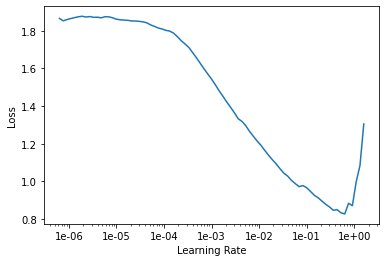

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
kappa = KappaScore()
learn.metrics = [accuracy]

In [ ]:
torch.cuda.empty_cache()


In [ ]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
learn.save('first_cls', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.453637,0.288522,0.907301,08:29
1,0.385648,0.260304,0.916386,08:44
2,0.328376,0.228165,0.920929,09:40


In [ ]:
!cp -r 'first_cls' 'drive/My Drive/nlp-telugu/ulmfit2'